# **Regresión Lineal**

### En este archivo desarrollaremos un modelo de regresión lineal. Este modelo nos predecirá el ganador de un partido.

Comenzamos importando todas las dependecias necesarias para el correcto funcionamiento del documento.

In [60]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Importamos los datos que usaremos para la predicción.

In [61]:
partidos = pd.read_csv('../../data/partidos_limpio.csv')

Vemos qué tipos de datos tenemos en nustra tabla. Aquellos datos que no sean numéricos debemos convertirlos para que nuestro modelo de regresión lineal los pueda entender.

In [62]:
partidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Season          598 non-null    object 
 1   Round           598 non-null    object 
 2   Day             598 non-null    object 
 3   Date            598 non-null    object 
 4   Results         598 non-null    object 
 5   Home            598 non-null    object 
 6   Country (Home)  598 non-null    object 
 7   Points (Home)   598 non-null    float64
 8   Score (Home)    598 non-null    int64  
 9   Score (Away)    598 non-null    int64  
 10  Points (Away)   598 non-null    float64
 11  Country (Away)  598 non-null    object 
 12  Away            598 non-null    object 
 13  Venue           598 non-null    object 
 14  Referee         598 non-null    object 
dtypes: float64(2), int64(2), object(11)
memory usage: 70.2+ KB


Usando Label Encoder transformamos los datos categóricos a numéricos. Las columnas 'Home' y 'Away', 'Country (Home)' y 'Country (Away)' las concatenamos antes de aplicar el Label Encoder ya que a pesar de ser columnas diferentes, sus valores describen lo mismo. Las concatenamos para que al aplicar Label Encoder se use el mismo diccionario de clave-valor para ambas columnas.

Además, la columna 'Date' la pasamos a datetime y la separamos en Año, Mes y Día para que esta fecha sea un dato numérico y podamos incluirlo en nuestro modelo.

In [63]:
# Columnas a modificar
cols = ['Season', 'Round', 'Day', 'Results', 'Home', 'Away', 'Country (Home)', 'Country (Away)', 'Venue', 'Referee']

# Inicializamos el label encoder
label_encoder = LabelEncoder()

# Creamos un diccionario para guardar los mapeos
mapping = {}

# Iteramos sobre las columnas y las transformamos
for col in cols:
    # Concatenamos los valores necesarios
    if col in ['Home', 'Away']:
        if 'Squad' not in mapping:
            name = 'Squad'
            squad = pd.concat([partidos['Home'], partidos['Away']])
            label_encoder.fit(squad)      
    elif col in ['Country (Home)', 'Country (Away)']:
        if 'Country' not in mapping:
            name = 'Country'
            country = pd.concat([partidos['Country (Home)'], partidos['Country (Away)']])
            label_encoder.fit(country)
    else:
        name = col
        label_encoder.fit(partidos[col])
    
    # Transformamos los valores 
    partidos[col] = label_encoder.transform(partidos[col])
    
    # Creamos un mapeo de los valores
    mapping[name] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Transformamos la columna 'Date' a datetime
partidos['Date'] = pd.to_datetime(partidos['Date'])

# Separar la fecha en año, mes y día
partidos['Year'] = partidos['Date'].dt.year
partidos['Month'] = partidos['Date'].dt.month
partidos['Number Day'] = partidos['Date'].dt.day # Lo llamamos 'Number Day' para evitar confusiones con la columna 'Day' que ya existe

# Eliminamos la columna 'Date'
partidos.drop('Date', axis=1, inplace=True)

# Verificamos los cambios
partidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Season          598 non-null    int32  
 1   Round           598 non-null    int32  
 2   Day             598 non-null    int32  
 3   Results         598 non-null    int32  
 4   Home            598 non-null    int32  
 5   Country (Home)  598 non-null    int32  
 6   Points (Home)   598 non-null    float64
 7   Score (Home)    598 non-null    int64  
 8   Score (Away)    598 non-null    int64  
 9   Points (Away)   598 non-null    float64
 10  Country (Away)  598 non-null    int32  
 11  Away            598 non-null    int32  
 12  Venue           598 non-null    int32  
 13  Referee         598 non-null    int32  
 14  Year            598 non-null    int64  
 15  Month           598 non-null    int64  
 16  Number Day      598 non-null    int64  
dtypes: float64(2), int32(10), int64(5)


Una vez convertidos todos los datos a numéricos, podemos comenzar a desarrollar nuestro modelo de regresión lineal.

In [64]:
# Definimos las variables X e y (variable objetivo)
X = partidos.drop(columns=['Results'])
y = partidos['Results']

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Creamos el modelo de regresión lineal y lo entrenamos
model = LinearRegression().fit(X_train, y_train)

# Realizamos predicciones
predictions = model.predict(X_test)
np.set_printoptions(suppress=True) # Evitamos la notación científica

# Comparamos las predicciones con los valores reales mostrando solo 10 valores en pantalla
print('Results         : ', mapping['Results']) # Mostramos el mapeo de los valores para saber a qué corresponde cada valor
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' ,y_test[:10].tolist())

Results         :  {'A': 0, 'D': 1, 'H': 2}
Predicted labels:  [1. 1. 2. 1. 0. 2. 1. 1. 3. 2.]
Actual labels   :  [0, 1, 2, 0, 0, 2, 1, 1, 2, 2]


Una vez entrenado el modelo y habiendo hecho predicciones, es hora de evaluarlo.

In [65]:
# Calculamos las métricas de evaluación

# MSE (Mean Squared Error) - Error Cuadrático Medio
# Sirve para medir la calidad de un estimador. Mientras más bajo sea el valor, mejor es el estimador
mse = mean_squared_error(y_test, predictions)
print("MSE :", mse)

# RMSE (Root Mean Squared Error) - Raíz del Error Cuadrático Medio
# Es la raíz cuadrada del MSE. Mientras más bajo sea el valor, mejor es el estimador
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# R2 (R cuadrado) - Coeficiente de determinación
# Es una medida que indica cuánto de la variabilidad de la variable dependiente es explicada por el modelo
r2 = r2_score(y_test, predictions)
print("R2  :", r2)

MSE : 0.24990186161465114
RMSE: 0.49990185198161763
R2  : 0.6632498620730869


- El MSE de aproximadamente 0.2499 indica una precisión razonable en las predicciones, con una baja discrepancia entre los valores predichos y reales.

- El RMSE de alrededor de 0.4999 representa la magnitud promedio de los errores en las predicciones, lo que sugiere una tolerancia aceptable en las estimaciones.

- El R2 de aproximadamente 0.6631 muestra que el modelo explica alrededor del 66.31% de la variabilidad en la variable dependiente. Aunque es un ajuste moderado, aún deja espacio para mejoras.

En resumen, el modelo de regresión lineal tiene un desempeño decente, pero aún se puede trabajar para mejorar su capacidad predictiva y explicativa. 

Por último, hagamos un gráfico que muestre los resultados que nuestro modelo ha predicho.

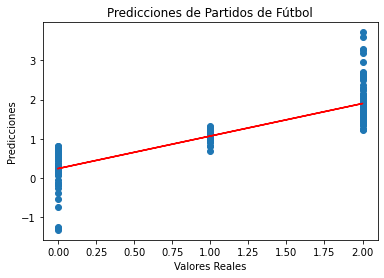

In [66]:
plt.scatter(y_test, predictions)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones de Partidos de Fútbol')

z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)

plt.plot(y_test,p(y_test), color='red')
plt.show()